Reference: https://www.kaggle.com/reynaldo/naive-xgb/comments/notebook

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import model_selection, preprocessing
import xgboost as xgb
import datetime
import math
from sklearn.metrics import make_scorer

pd.options.display.max_columns = 300
%matplotlib inline  

In [83]:
df_train = pd.read_csv('clean_train.csv')#, parse_dates=['timestamp'])
df_test = pd.read_csv('clean_test.csv')#, parse_dates=['timestamp'])
# df_macro = pd.read_csv('macro.csv')#, parse_dates=['timestamp'])
id_test = df_test.id
df_train.sample(3)

/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (348,351,352) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (350,351) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,radiation_raion,big_market_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road2_km,ID_big_road2,railroad_km,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,trc_count_500,cafe_count_500,...,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,eurrub,brent,net_capital_export,gdp_annual,gdp_annual_growth,average_provision_of_build_contract,average_provision_of_build_contract_moscow,rts,micex,micex_rgbi_tr,micex_cbi_tr,deposits_value,deposits_growth,deposits_rate,mortgage_value,mortgage_growth,mortgage_rate,grp,grp_growth,income_per_cap,real_dispos_income_per_cap_growth,salary,salary_growth,fixed_basket,retail_trade_turnover,retail_trade_turnover_per_cap,retail_trade_turnover_growth,labor_force,unemployment,employment,invest_fixed_capital_per_cap,invest_fixed_assets,profitable_enterpr_share,unprofitable_enterpr_share,share_own_revenues,overdue_wages_pe

In [85]:
y_train = df_train["price_doc"]
x_train = df_train.drop(["id", "price_doc"], axis=1)
x_test = df_test.drop(["id"], axis=1)

#can't merge train with test because the kernel run for very long time

for c in x_train.columns:
    if x_train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[c].values)) 
        x_train[c] = lbl.transform(list(x_train[c].values))
        #x_train.drop(c,axis=1,inplace=True)
        
for c in x_test.columns:
    if x_test[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[c].values)) 
        x_test[c] = lbl.transform(list(x_test[c].values))
        #x_test.drop(c,axis=1,inplace=True)   

In [86]:
# Train/Valid split
split = 25000
df_val = df_train[split:]
print df_val.shape
x_tr, y_tr, x_val, y_val = x_train[:split], y_train[:split], x_train[split:], y_train[split:]
x_tr.shape, y_tr.shape, x_val.shape, y_val.shape

(5471, 376)


((25000, 374), (25000,), (5471, 374), (5471,))

In [88]:
# trainsub = df_val[df_val.timestamp < '2015-01-01']
trainsub = trainsub[trainsub.product_type=="Investment"]

ind_1m = trainsub[trainsub.price_doc <= 1000000].index
ind_2m = trainsub[trainsub.price_doc == 2000000].index
ind_3m = trainsub[trainsub.price_doc == 3000000].index

train_index = set(df_val.index.copy())

for ind, gap in zip([ind_1m, ind_2m, ind_3m], [10, 3, 2]):
    ind_set = set(ind)
    ind_set_cut = ind.difference(set(ind[::gap]))

    train_index = train_index.difference(ind_set_cut)

df_val = df_val.loc[train_index]
print df_val.shape

y_val = df_val["price_doc"]
x_val = df_val.drop(["id", "price_doc"], axis=1)
for c in x_val.columns:
    if x_val[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_val[c].values)) 
        x_val[c] = lbl.transform(list(x_val[c].values))
        #x_train.drop(c,axis=1,inplace=True)

(5368, 376)


In [89]:
# def rmsle_XGB(labels, preds):
#     labels = labels.tolist()
# #     preds = preds.tolist()
# #     print len(labels), len(preds)
#     terms_to_sum = [(math.log(labels[i] + 1) - math.log(max(0, preds[i]) + 1)) ** 2.0 for i, pred in enumerate(labels)]
#     return (sum(terms_to_sum) * (1.0 / len(preds))) ** 0.5

# rmsle_scorer = make_scorer(rmsle_XGB, greater_is_better=False)#, needs_proba=True)

def rmsle_XGB(preds, dtrain):
    labels = dtrain.get_label()
    assert len(preds) == len(labels)
    labels = labels.tolist()
    preds = preds.tolist()
    terms_to_sum = [(math.log(labels[i] + 1) - math.log(max(0, preds[i]) + 1)) ** 2.0 for i in range(len(labels))]
    return 'rmsle', (sum(terms_to_sum) * (1.0 / len(preds))) ** 0.5

In [90]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
#     'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(x_tr, y_tr)
dval = xgb.DMatrix(x_val, y_val)
dtest = xgb.DMatrix(x_test)

In [91]:
# cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
#     verbose_eval=1, show_stdv=False, feval=rmsle_XGB)
# cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

cv_output = xgb.train(xgb_params, dtrain, num_boost_round=1000, evals=[(dval, 'val')], early_stopping_rounds=20,
    verbose_eval=10, feval=rmsle_XGB)
# partial_model = xgb.train(xgb_params, dtrain, num_boost_round=1000, evals=[(dval, 'val')],
#                        early_stopping_rounds=20, verbose_eval=20)
# [402]	train-rmse:1.7542e+06	test-rmse:2.627e+06

# cv_output[['train-rmsle-mean', 'test-rmsle-mean']].plot()
# [72]	train-rmsle:0.462161	test-rmsle:0.4756

[0]	val-rmsle:3.09037
Will train until val-rmsle hasn't improved in 20 rounds.
[10]	val-rmsle:0.95997
[20]	val-rmsle:0.590621
[30]	val-rmsle:0.458279
[40]	val-rmsle:0.408262
[50]	val-rmsle:0.387381
[60]	val-rmsle:0.377543
[70]	val-rmsle:0.37242
[80]	val-rmsle:0.369334
[90]	val-rmsle:0.367518
[100]	val-rmsle:0.365788
[110]	val-rmsle:0.364343
[120]	val-rmsle:0.36312
[130]	val-rmsle:0.361902
[140]	val-rmsle:0.36126
[150]	val-rmsle:0.360584
[160]	val-rmsle:0.359863
[170]	val-rmsle:0.35935
[180]	val-rmsle:0.358703
[190]	val-rmsle:0.358371
[200]	val-rmsle:0.358188
[210]	val-rmsle:0.358033
[220]	val-rmsle:0.357647
[230]	val-rmsle:0.357275
[240]	val-rmsle:0.357362
[250]	val-rmsle:0.356698
[260]	val-rmsle:0.356487
[270]	val-rmsle:0.356318
[280]	val-rmsle:0.356421
[290]	val-rmsle:0.356018
[300]	val-rmsle:0.355975
[310]	val-rmsle:0.355833
[320]	val-rmsle:0.355744
[330]	val-rmsle:0.355912
Stopping. Best iteration:
[314]	val-rmsle:0.355664



In [79]:
num_boost_rounds = num_boost_round = cv_output.best_iteration
# len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

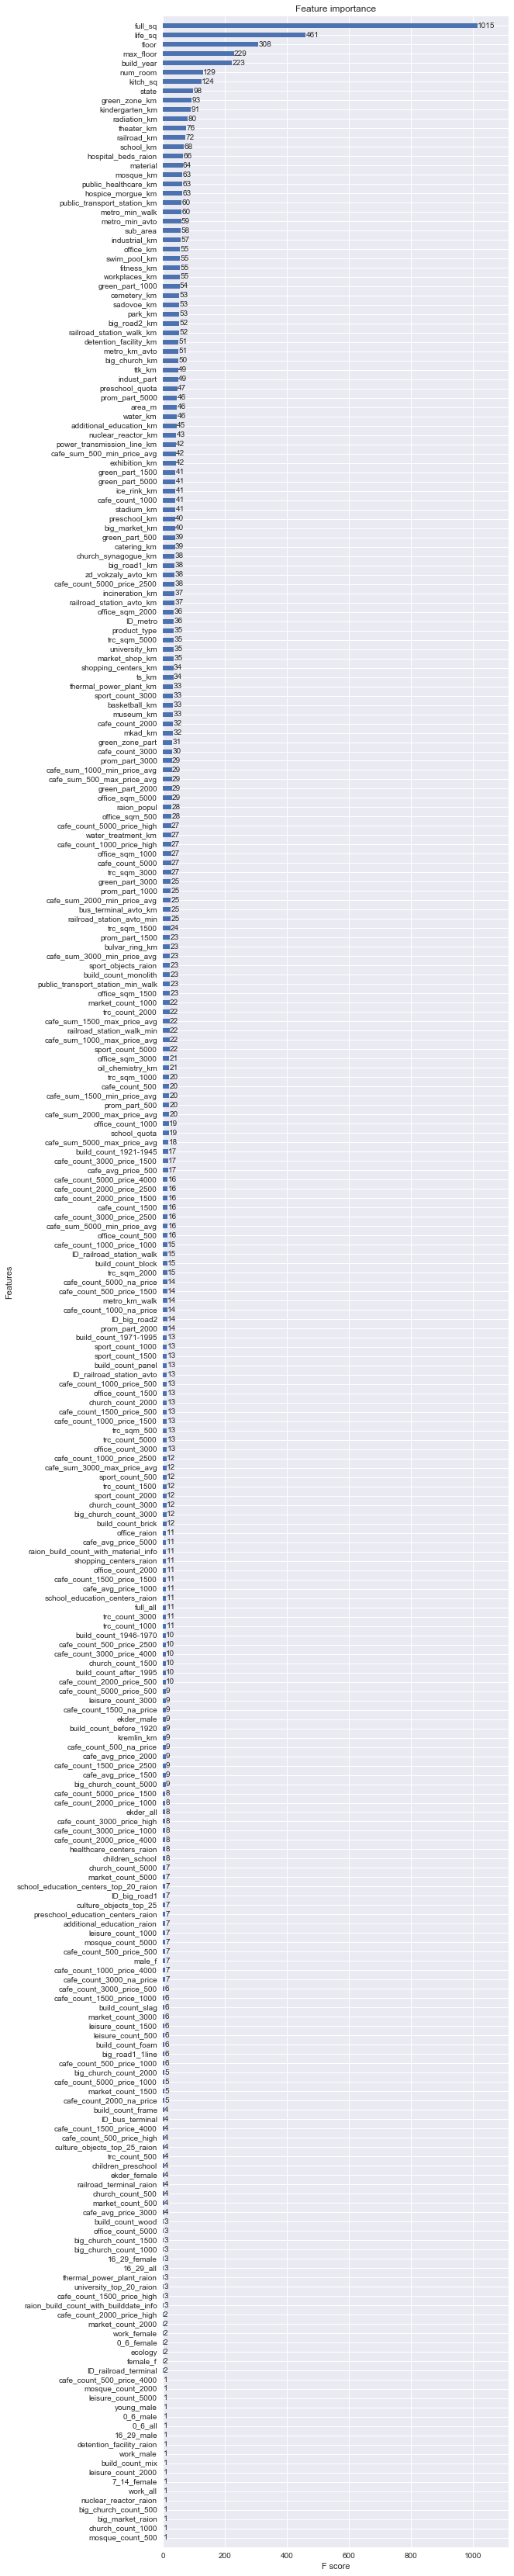

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(8, 60))
xgb.plot_importance(model, height=0.5, ax=ax)

In [81]:
def rmsle_XGB(preds, dtrain):
    labels = dtrain#.get_label()
    assert len(preds) == len(labels)
    labels = labels.tolist()
    preds = preds.tolist()
    terms_to_sum = [(math.log(labels[i] + 1) - math.log(max(0, preds[i]) + 1)) ** 2.0 for i, pred in enumerate(labels)]
    return 'rmsle', (sum(terms_to_sum) * (1.0 / len(preds))) ** 0.5

In [82]:
y_pred = model.predict(dtrain)
print 'Train:', rmsle_XGB(y_pred, y_train)

# y_pred = model.predict(dval)
# print 'Validation:', rmsle_XGB(y_pred, y_val)

Train:

AssertionError: 

In [11]:
y_predict = model.predict(dtest)
output = pd.DataFrame({'id': id_test, 'price_doc': y_predict})
output

,id,price_doc
0,30474,5.448556e+06
1,30475,8.517570e+06
2,30476,5.389902e+06
3,30477,5.937156e+06
4,30478,5.151572e+06
5,30479,9.654658e+06
6,30480,4.333713e+06
7,30481,4.356614e+06
8,30482,4.778176e+06
9,30483,4.909882e+06


In [28]:
output.to_csv('submissions/xgb3_.csv', index=False)